# Necessary Packages

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.src.models import Sequential
from keras.src.layers import Dense, LSTM, Dropout
from keras.src.regularizers import L2
from keras.src.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# LSTM Experiment 1
- This LSTM only imputes the data, it does nothing else to infuence the data or the model. In other words these are fairly standard parameters for and LSTM model.

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - loss: 121.1743 - val_loss: 94.0593
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 123.8163 - val_loss: 93.7401
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 120.2906 - val_loss: 93.3998
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 123.0616 - val_loss: 93.0039
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 121.6574 - val_loss: 92.5136
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 119.6156 - val_loss: 91.8995
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 120.2579 - val_loss: 91.1214
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 119.8758 - val_loss: 90.1042
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 117.7922 - val_loss: 88.7510
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 117.3010 - val_loss: 86.9261
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 115.7364 - val_loss: 84.4365
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step -

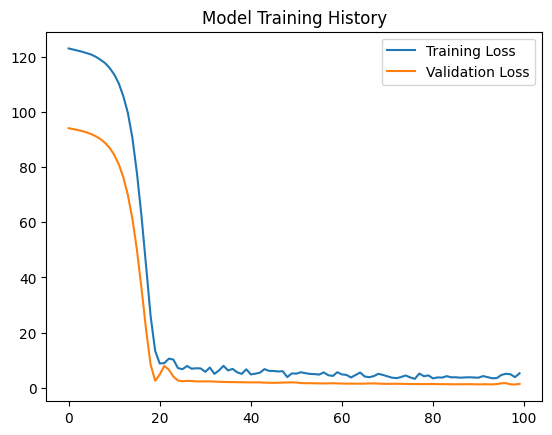

In [62]:

# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(1, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 14: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

## LSTM 1 : Metrics Table

In [63]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "RMSE", "MAPE (%)"],
    "Train": [mse_train, rmse_train, mape_train],
    "Test": [mse_test, rmse_test, mape_test]
})

print("LSTM 4 Model Metrics: Early Stopping\n")
print(results)

LSTM 4 Model Metrics: Early Stopping

     Metric     Train       Test
0       MSE  1.369176   6.387119
1      RMSE  1.170118   2.527275
2  MAPE (%)  9.202571  18.867158


## Visualizing RMSE for LSTM #1

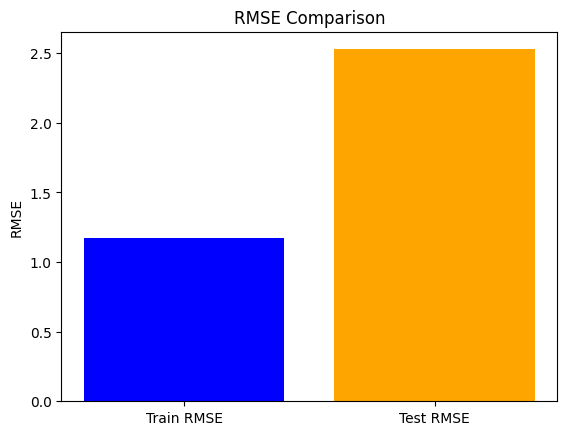

In [64]:
# Visualize RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

plt.bar(['Train RMSE', 'Test RMSE'], [train_rmse, test_rmse], color=['blue', 'orange'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

## Test Data : Predicted vs Actual

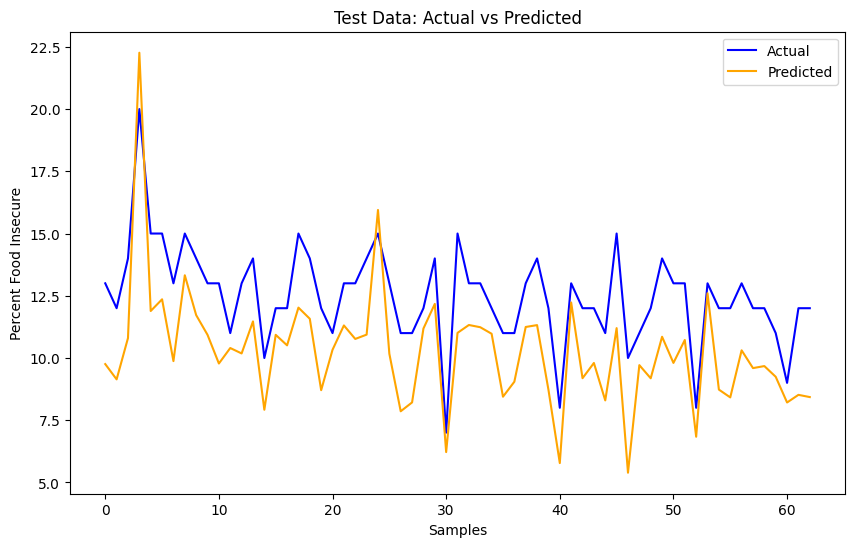

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(test_pred, label='Predicted', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Percent Food Insecure')
plt.legend()
plt.show()

## Residual Analysis

### Training Residuals

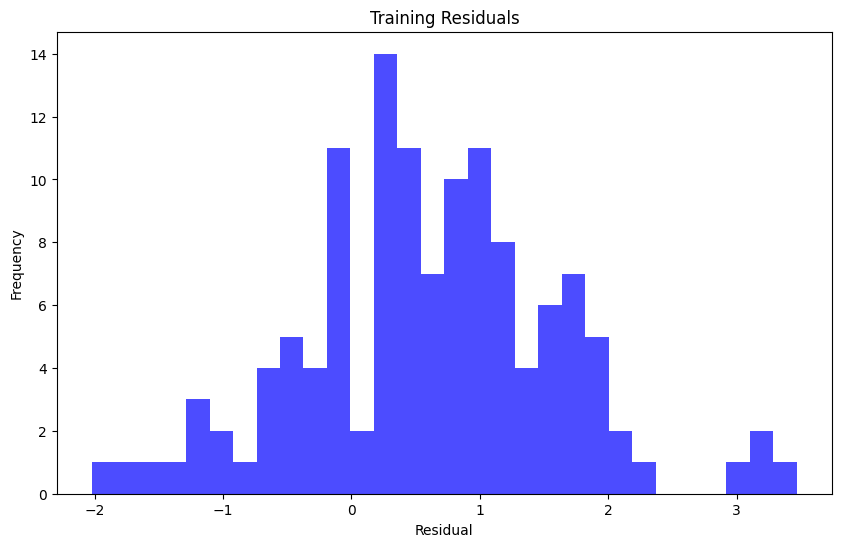

In [66]:
train_residuals = y_train - train_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(train_residuals, bins=30, color='blue', alpha=0.7)
plt.title('Training Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

### Test Residuals

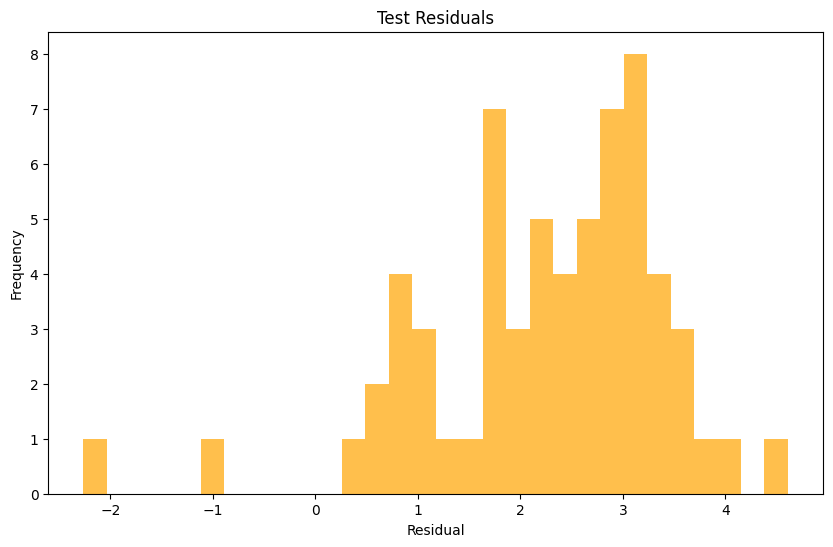

In [67]:
test_residuals = y_test - test_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(test_residuals, bins=30, color='orange', alpha=0.7)
plt.title('Test Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

## Training Loss Curve

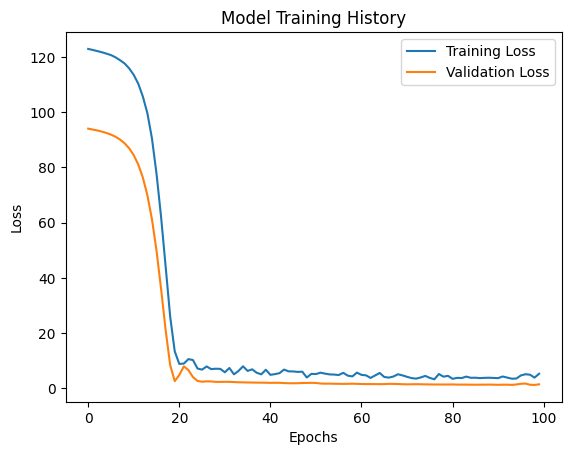

In [68]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Highest percentage yearly change in food insecurity

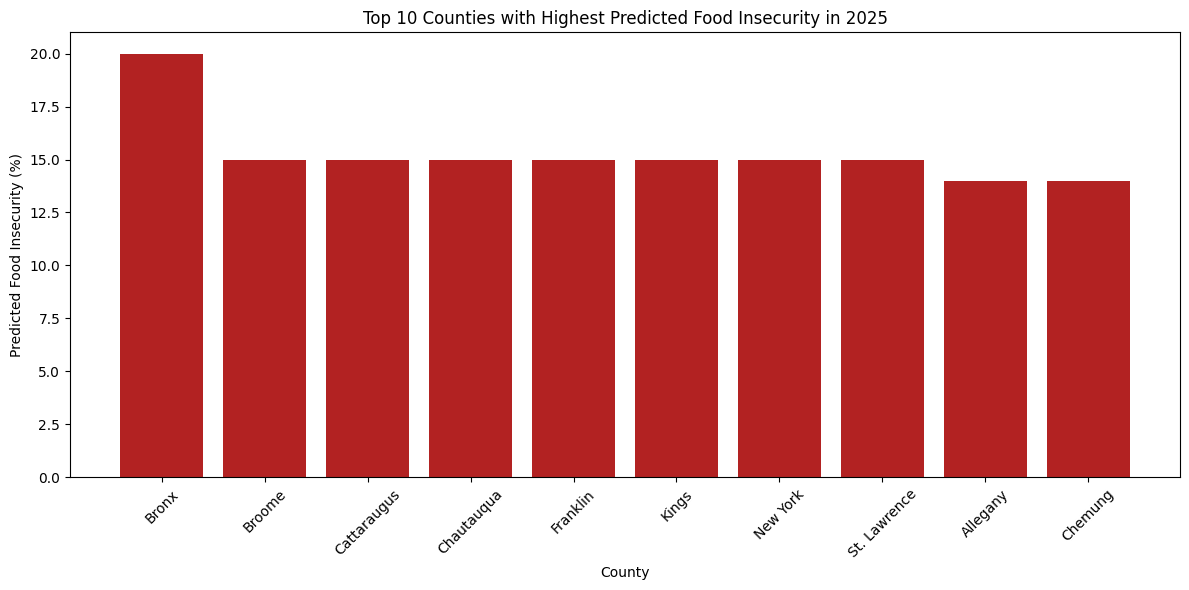

In [69]:
top_10_counties = test.nlargest(10, 'percent_food_insecure')

plt.figure(figsize=(12, 6))
plt.bar(top_10_counties['county.x'], top_10_counties['percent_food_insecure'], color='firebrick')
plt.title('Top 10 Counties with Highest Predicted Food Insecurity in 2025')
plt.xlabel('County')
plt.ylabel('Predicted Food Insecurity (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scatter Plot Analysis: Actual vs Predicted

### Training Scatter

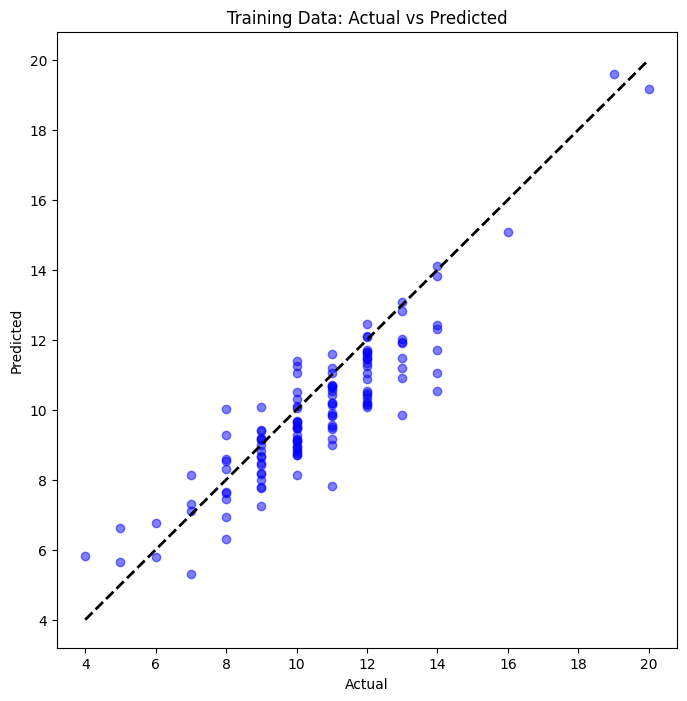

In [70]:
plt.figure(figsize=(8, 8))
plt.scatter(y_train, train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### Test Scatter

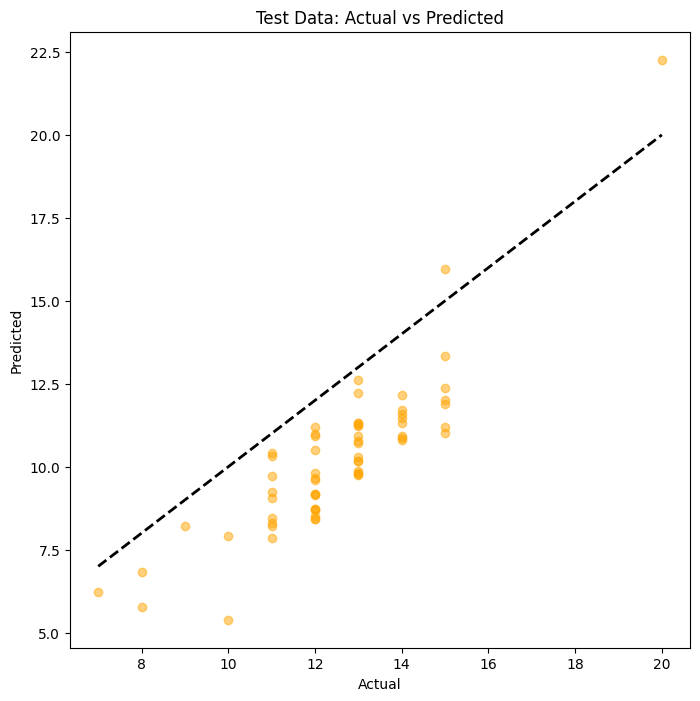

In [71]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_pred, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# LSTM Experiment 2:
- This LSTM model attempts to increase the amount of n_steps which will bring in more historical data into the prediction. Aiding the model in leaning temporal patterns more effectively

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - loss: 108.3271 - val_loss: 79.9419
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 106.6932 - val_loss: 79.6854
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 101.9449 - val_loss: 79.4024
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 104.9931 - val_loss: 79.0831
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 102.9280 - val_loss: 78.7074
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 103.7468 - val_loss: 78.2876
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 102.0305 - val_loss: 77.8189
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 104.3577 - val_loss: 77.2867
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 102.2439 - val_loss: 76.6702
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 101.3253 - val_loss: 75.9463
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 99.5147 - val_loss: 75.0845
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - 

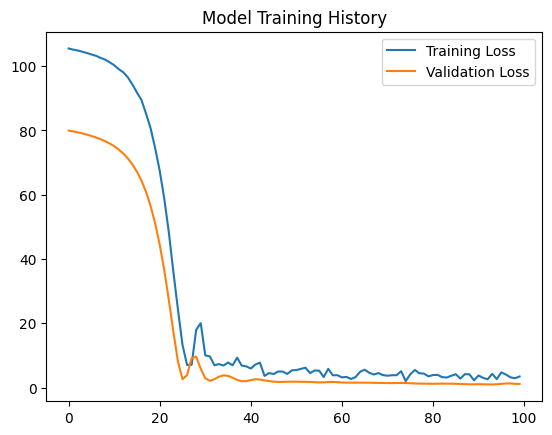

In [72]:

# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(2, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 14: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

## LSTM 2 : Metrics Table

In [73]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "RMSE", "MAPE (%)"],
    "Train": [mse_train, rmse_train, mape_train],
    "Test": [mse_test, rmse_test, mape_test]
})

print("LSTM 4 Model Metrics: Early Stopping\n")
print(results)

LSTM 4 Model Metrics: Early Stopping

     Metric     Train       Test
0       MSE  1.116986  13.356785
1      RMSE  1.056876   3.654694
2  MAPE (%)  8.784621  27.891186


## LSTM 2 : RMSE Training vs Testing 

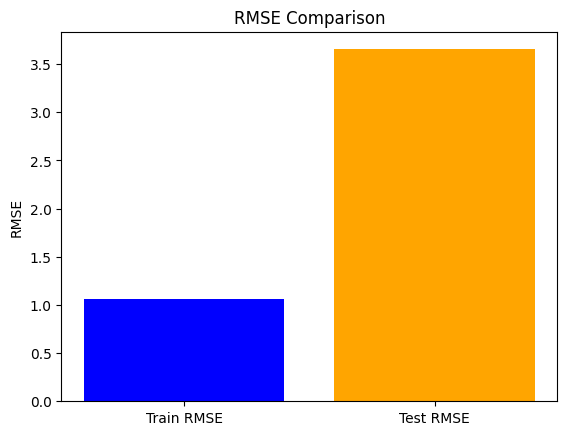

In [74]:
# Visualize RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

plt.bar(['Train RMSE', 'Test RMSE'], [train_rmse, test_rmse], color=['blue', 'orange'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

## LSTM 2: Test Data: Predicted vs Actual

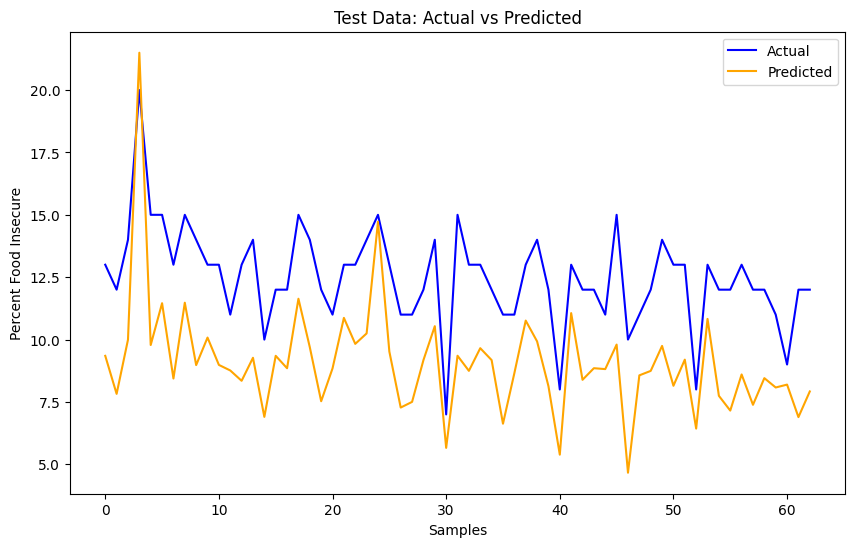

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(test_pred, label='Predicted', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Percent Food Insecure')
plt.legend()
plt.show()

## Residual Analysis : LSTM 2  

### Training

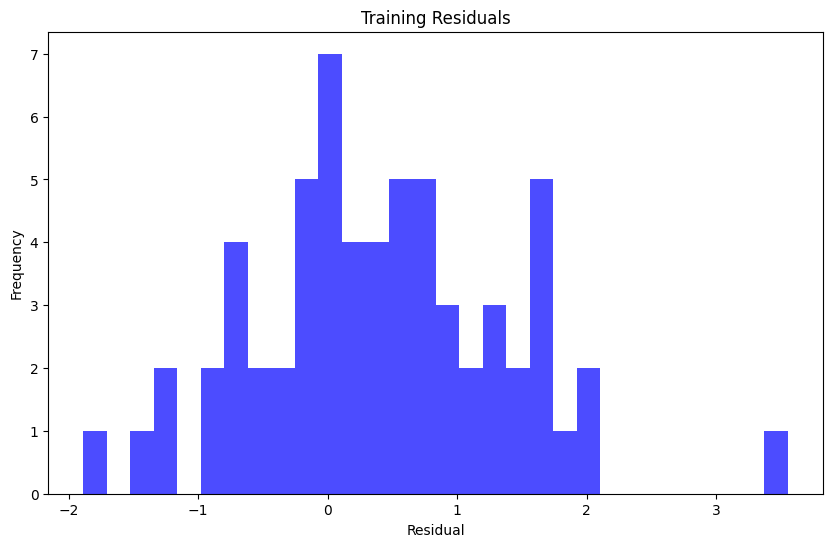

In [76]:
train_residuals = y_train - train_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(train_residuals, bins=30, color='blue', alpha=0.7)
plt.title('Training Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

### Testing

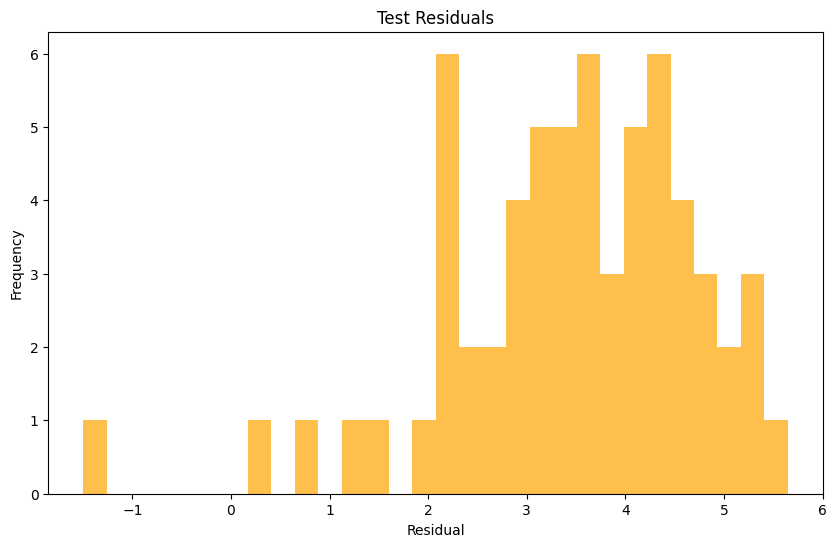

In [77]:
test_residuals = y_test - test_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(test_residuals, bins=30, color='orange', alpha=0.7)
plt.title('Test Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# LSTM Experiment 3: 
- This experiment aims at introducing regularization to the data, l2 regularization from keras will be used here

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 126.8161 - val_loss: 95.3188
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 123.6426 - val_loss: 94.8970
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 122.5877 - val_loss: 94.4663
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 121.2877 - val_loss: 93.9817
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 118.1798 - val_loss: 93.4112
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 122.2093 - val_loss: 92.7243
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 120.6316 - val_loss: 91.8696
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 120.4928 - val_loss: 90.7757
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 120.9393 - val_loss: 89.3602
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 120.6649 - val_loss: 87.4968
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 111.7802 - val_loss: 85.0104
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step -

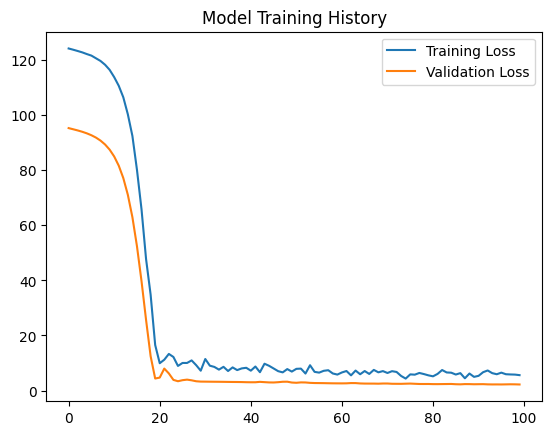

In [78]:
# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(1, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True, kernel_regularizer=L2 (0.01)),
    Dropout(0.25),
    LSTM(50, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 14: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

## LSTM 3 : Metrics Table
- MAPE and MSE

In [79]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "RMSE", "MAPE (%)"],
    "Train": [mse_train, rmse_train, mape_train],
    "Test": [mse_test, rmse_test, mape_test]
})

print("LSTM 4 Model Metrics: Early Stopping\n")
print(results)

LSTM 4 Model Metrics: Early Stopping

     Metric     Train       Test
0       MSE  1.185769   4.735223
1      RMSE  1.088930   2.176057
2  MAPE (%)  8.900780  15.370359


# LSTM Experiment 4: (Best Performing)
- This experiment will be introducing early stopping to try and limit the overfitting in the model

Step 2: Data loaded
   year   fips   state.x  county.x  \
0  2025  36000  New York     Total   
1  2025  36001  New York    Albany   
2  2025  36003  New York  Allegany   
3  2025  36005  New York     Bronx   
4  2025  36007  New York    Broome   

   percent_household_income_required_for_child_care_expenses  \
0                                               38.0           
1                                               37.0           
2                                               43.0           
3                                               65.0           
4                                               39.0           

   food_environment_index  percent_fair_or_poor_health  percent_unemployed  \
0                     8.7                           16                 4.2   
1                     8.4                           12                 3.3   
2                     8.2                           16                 4.3   
3                     7.1                           28


Step: Imputed missing values
year                                                         0
fips                                                         0
state.x                                                      0
county.x                                                     0
percent_household_income_required_for_child_care_expenses    0
food_environment_index                                       0
percent_fair_or_poor_health                                  0
percent_unemployed                                           0
percent_children_in_poverty                                  0
percent_severe_housing_problems                              0
percent_completed_high_school                                0
percent_food_insecure                                        0
percent_frequent_mental_distress                             0
percent_uninsured_children                                   0
percent_disconnected_youth                                   0
spending_per_pupil       

c:\Users\jashb\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 123.8736 - val_loss: 95.3892
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 126.7315 - val_loss: 94.9686
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 126.3933 - val_loss: 94.5560
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 125.7295 - val_loss: 94.0876
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 121.6402 - val_loss: 93.5345
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 124.3701 - val_loss: 92.8647
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 117.2583 - val_loss: 92.0338
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 120.9567 - val_loss: 90.9542
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 122.0493 - val_loss: 89.5355
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 115.1935 - val_loss: 87.6362
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 111.4071 - val_loss: 85.0602
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step -

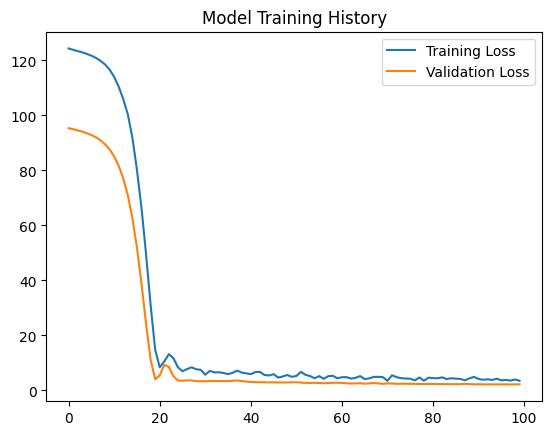

In [80]:
# Step 2: Load data
filepath = "C:\\Users\\jashb\\OneDrive\\Documents\\Masters Data Science\\Spring 2025\\DATA 698\\Masters Project\\final_data.csv"
df = pd.read_csv(filepath)
print("Step 2: Data loaded")
print(df.head())
# Step: Impute missing values
# Impute numeric columns with their mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Impute categorical columns with the most frequent value
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("\nStep: Imputed missing values")
print(df.isnull().sum())  # Verify no missing values remain

# Step: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep: Dropped rows with missing 'percent_food_insecure'")
print(df.head())
# Step 3: Drop rows with missing target
df = df.dropna(subset=['percent_food_insecure'])
print("\nStep 3: Dropped rows with missing 'percent_food_insecure'")
print(df.head())

# Step 4: Convert 'rural_urban' to numeric
df['rural_urban'] = pd.factorize(df['rural_urban'])[0]
print("\nStep 4: Converted 'rural_urban' to numeric")
print(df[['rural_urban']].head())

# Step 5: Create lag features
df = df.sort_values(['fips', 'year'])
df['food_insecure_lag1'] = df.groupby('fips')['percent_food_insecure'].shift(1)
df['food_insecure_lag2'] = df.groupby('fips')['percent_food_insecure'].shift(2)
print("\nStep 5: Created lag features")
print(df[['fips', 'year', 'percent_food_insecure', 'food_insecure_lag1', 'food_insecure_lag2']].head())

# Step 6: Drop rows with missing lag features
df = df.dropna(subset=['food_insecure_lag1', 'food_insecure_lag2'])
print("\nStep 6: Dropped rows with missing lag features")
print(df.head())

# Step 7: Select features
features = [
    'percent_household_income_required_for_child_care_expenses',
    'food_environment_index',
    'percent_fair_or_poor_health',
    'percent_unemployed',
    'percent_children_in_poverty',
    'percent_severe_housing_problems',
    'percent_completed_high_school',
    'percent_frequent_mental_distress',
    'percent_uninsured_children',
    'percent_disconnected_youth',
    'spending_per_pupil',
    'school_funding_adequacy',
    'high_school_graduation_rate',
    'median_household_income',
    'gender_pay_gap',
    'percent_enrolled_in_free_or_reduced_lunch',
    'percent_households_with_severe_cost_burden',
    'percent_rural',
    'percent_65_and_over',
    'percent_not_proficient_in_english',
    'segregation_index',
    'teen_birth_rate',
    'percent_children_in_single_parent_households',
    'percent_low_birthweight',
    'percent_black',
    'rural_urban',
    'food_insecure_lag1',
    'food_insecure_lag2'
]

available_features = [f for f in features if f in df.columns]
df = df[['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'] + available_features]
print("\nStep 7: Selected features")
print(df.head())

# Step 8: Analyze data
print("\nStep 8: Data Analysis")
print(f"Years available: {sorted(df['year'].unique())}")
print(f"Counties with data: {df['fips'].nunique()}")

county_years = df.groupby('fips')['year'].count()
print(f"\nMinimum years per county: {county_years.min()}")
print(f"Maximum years per county: {county_years.max()}")

# Step 9: Set n_steps
min_years = county_years.min()
n_steps = min(1, min_years)  # Use 3 if possible, otherwise use the minimum available
print(f"Using n_steps = {n_steps}")

# Step 10: Split data into train and test
latest_year = df['year'].max()
train = df[df['year'] < latest_year]
test = df[df['year'] == latest_year]
print(f"\nTraining years: {sorted(train['year'].unique())}")
print(f"Test year: {test['year'].unique()}")

# Step 11: Prepare training data
counties = train['fips'].unique()
X_train, y_train = [], []
scaler = MinMaxScaler()

all_features = train.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
scaler.fit(all_features)

for county in counties:
    county_data = train[train['fips'] == county].sort_values('year')
    if len(county_data) < n_steps:
        continue
    features = county_data.drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data['percent_food_insecure'].values
    scaled_features = scaler.transform(features)
    for i in range(n_steps, len(county_data)):
        X_train.append(scaled_features[i-n_steps:i])
        y_train.append(target[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Check if X_train is empty
if len(X_train) == 0:
    raise ValueError("No training data available. Check your data or reduce n_steps.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
# Step 12: Prepare test data
X_test, y_test = [], []
test_counties = test['fips'].unique()

for county in test_counties:
    county_data = df[(df['fips'] == county) & (df['year'] <= latest_year)].sort_values('year')
    if len(county_data) < n_steps + 1:  # Need n_steps years + target year
        continue
    # Get features from n_steps previous years
    features = county_data.iloc[-(n_steps+1):-1].drop(columns=['year', 'fips', 'county.x', 'state.x', 'percent_food_insecure'])
    target = county_data.iloc[-1]['percent_food_insecure']
    scaled_features = scaler.transform(features)
    X_test.append(scaled_features)
    y_test.append(target)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTest data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Step 13: Build LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential([
    LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True, kernel_regularizer=L2 (0.01)),
    Dropout(0.15),
    LSTM(50, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.15),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# An early stopping callback to attempt to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,         # Stop training after 10 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)
# Step 14: Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]  # Add the callback here
)

# Step 15: Evaluate the model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(f"\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, train_pred))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred))}")

# Step 16: Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

## LSTM 4 : Metrics Table

In [81]:
import pandas as pd

# Calculate MSE
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calculate MAPE
mape_train = np.mean(np.abs((y_train - train_pred.flatten()) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - test_pred.flatten()) / y_test)) * 100

# Create a table
results = pd.DataFrame({
    "Metric": ["MSE", "RMSE", "MAPE (%)"],
    "Train": [mse_train, rmse_train, mape_train],
    "Test": [mse_test, rmse_test, mape_test]
})

print("LSTM 4 Model Metrics: Early Stopping\n")
print(results)

LSTM 4 Model Metrics: Early Stopping

     Metric     Train       Test
0       MSE  1.098105   5.054720
1      RMSE  1.047905   2.248270
2  MAPE (%)  8.393658  16.058777


## Visualizing the best performing LSTM Model
- This model was an L2 regularized model, with early stopping added to aid the model from overfitting.

1. Training and Validation Loss Curve

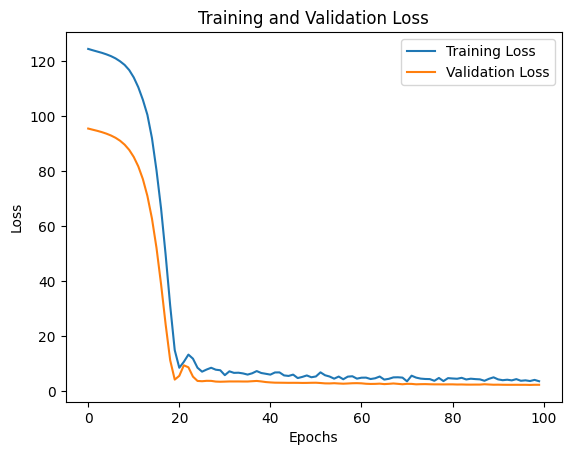

In [82]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

2. RMSE Comparison (Train vs Test)


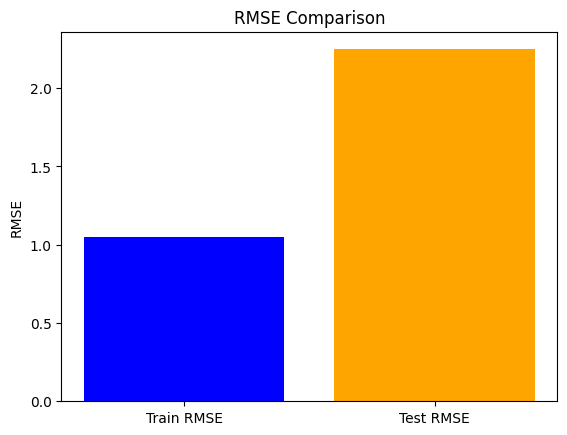

In [83]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

plt.bar(['Train RMSE', 'Test RMSE'], [train_rmse, test_rmse], color=['blue', 'orange'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

3. Predicted vs Actual (Test Data)

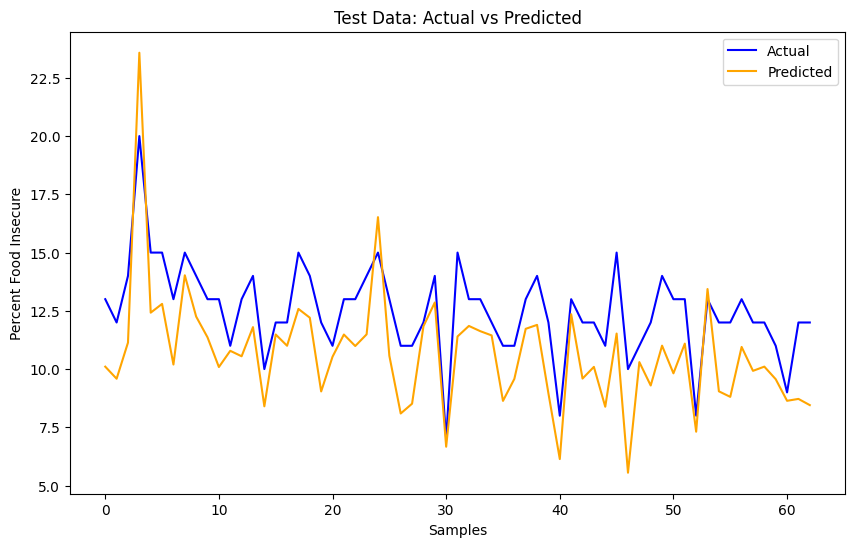

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(test_pred, label='Predicted', color='orange')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Percent Food Insecure')
plt.legend()
plt.show()

4. Residual Analysis (Train and Test)

Training Resid

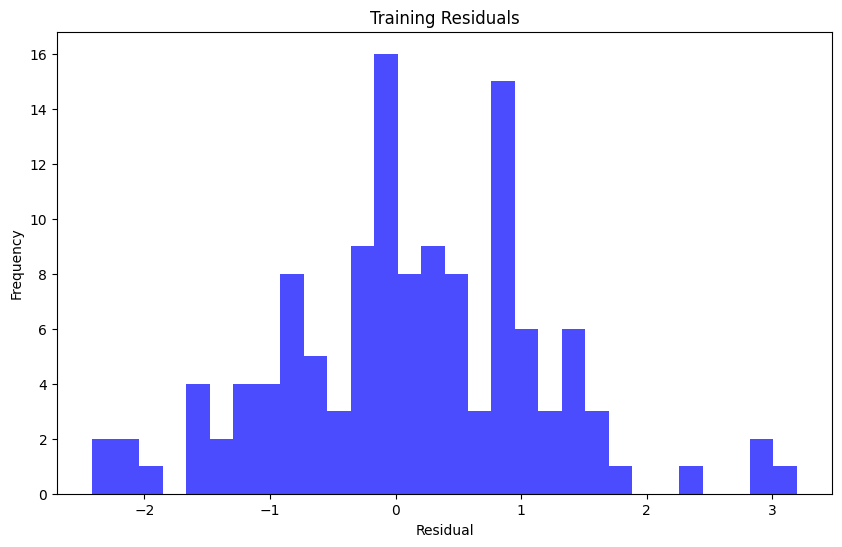

In [85]:
train_residuals = y_train - train_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(train_residuals, bins=30, color='blue', alpha=0.7)
plt.title('Training Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

Testing Resid

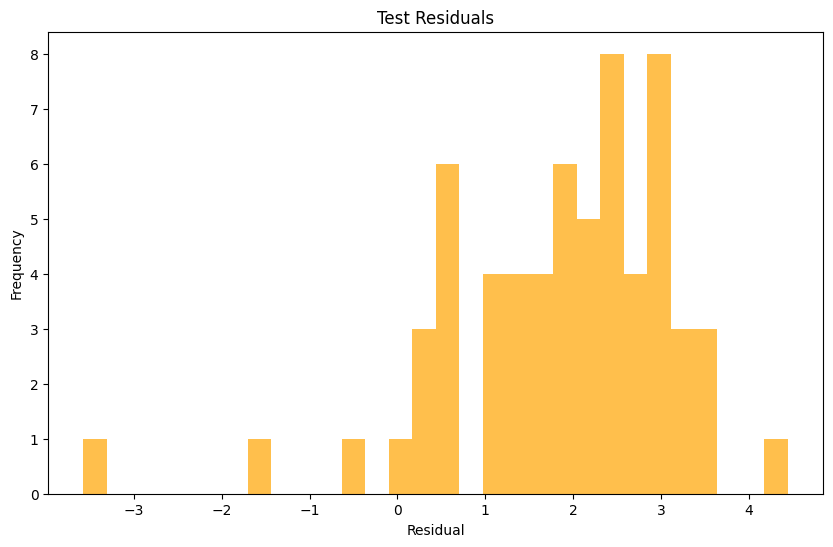

In [86]:
test_residuals = y_test - test_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(test_residuals, bins=30, color='orange', alpha=0.7)
plt.title('Test Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

5. Scatter Plot: Actual vs Predicted

Training Data

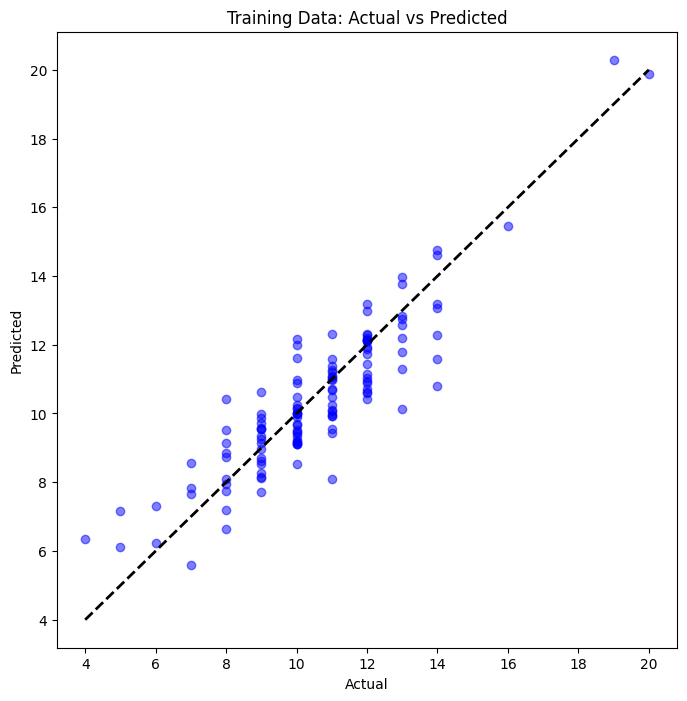

In [87]:
plt.figure(figsize=(8, 8))
plt.scatter(y_train, train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Test Data

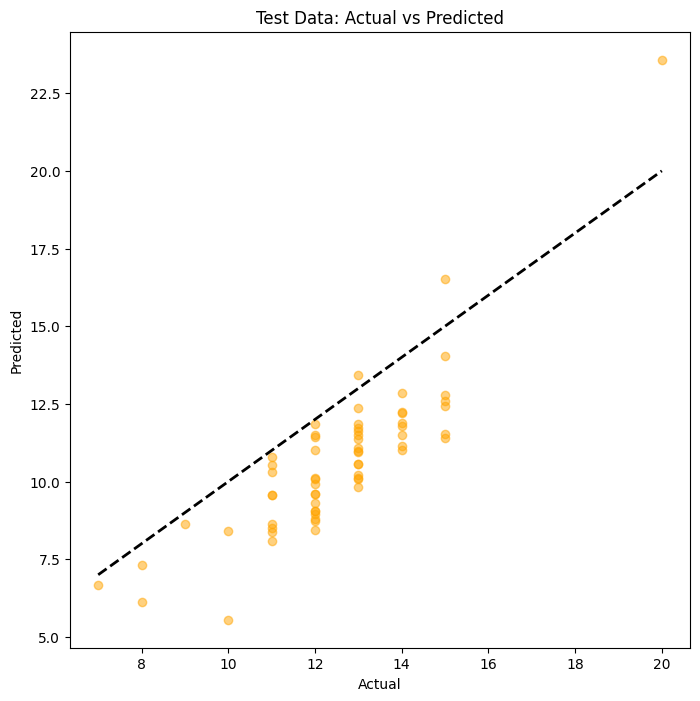

In [88]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_pred, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

6. Predicted Values Table

In [89]:
predicted_vs_actual = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_pred.flatten()
})
print(predicted_vs_actual)  # Display the first 10 rows

    Actual  Predicted
0       13  10.104425
1       12   9.586191
2       14  11.137208
3       20  23.577702
4       15  12.421782
..     ...        ...
58      12  10.105597
59      11   9.566097
60       9   8.639240
61      12   8.720520
62      12   8.454118

[63 rows x 2 columns]


7. Top Counties with Highest Predicted Food Insecurity

C:\Users\jashb\AppData\Local\Temp\ipykernel_1536\1192875939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted'] = test_pred.flatten()


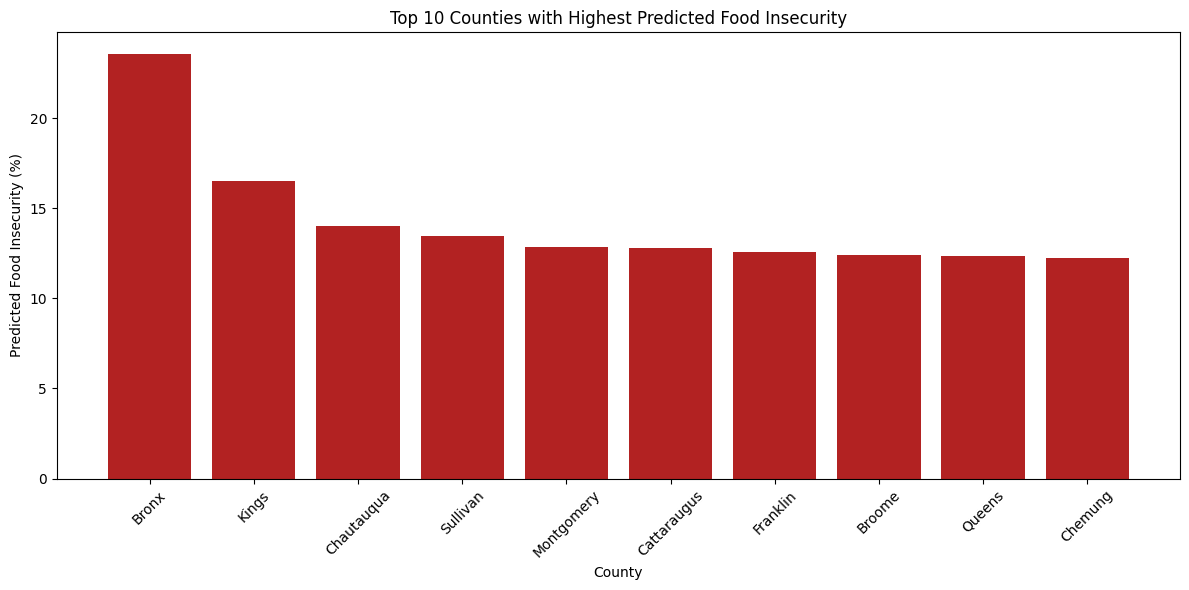

In [90]:
test['Predicted'] = test_pred.flatten()
top_10_counties = test.nlargest(10, 'Predicted')

plt.figure(figsize=(12, 6))
plt.bar(top_10_counties['county.x'], top_10_counties['Predicted'], color='firebrick')
plt.title('Top 10 Counties with Highest Predicted Food Insecurity')
plt.xlabel('County')
plt.ylabel('Predicted Food Insecurity (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()